# 1. Introuction

 This notebook outlines the creation, compilation, and training of a ViT network to classify 101 types of food. An extra class called "unknown" was created using images from the [iFood-2019 dataset](https://www.kaggle.com/competitions/ifood-2019-fgvc6/data) that contains 251 food types. As in the other trained models, PyTorch's pretrained weights will be used to initialize the models and no transfer learning will be applied. 
 
 The following table summarizes the model:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

The custom vision transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import shutil

from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Engine
from modules.vision_transformer import ViT
from modules.schedulers import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders_for_vit
#from modules.scheduler import WarmupCosineAnnealingLR


# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Mon Jan 27 22:16:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 40%   52C    P8             13W /  200W |    1063MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

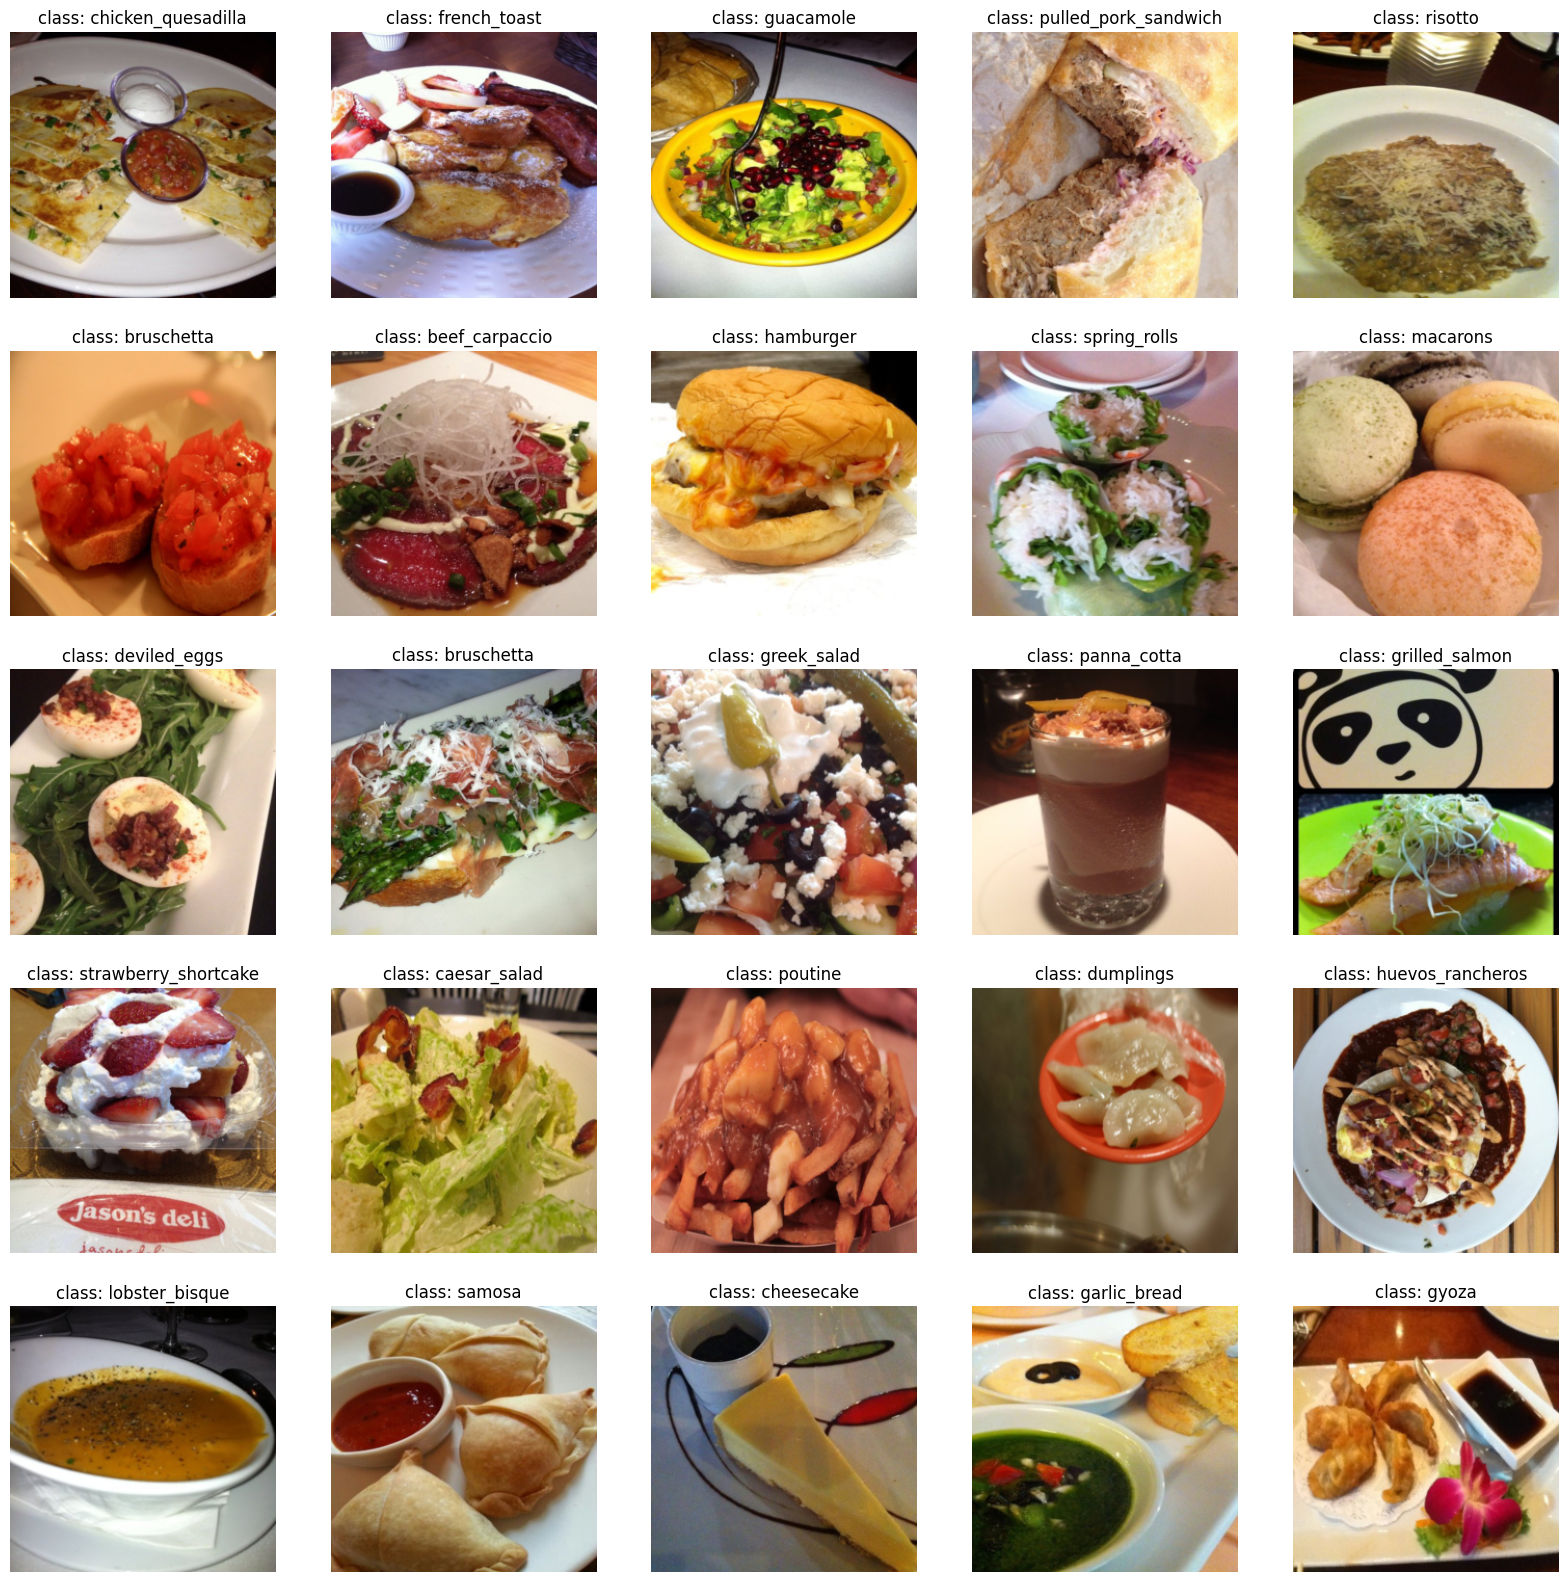

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's ViT-Base/16 - 101 Classes

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

In [4]:
# Remove the unknown class into the dataset
path_train = os.path.join(TRAIN_DIR, "unknown")
path_test =  os.path.join(TEST_DIR, "unknown")

# Check if the directory exists before trying to remove it
if os.path.exists(path_train):
    shutil.rmtree(path_train)
if os.path.exists(path_test):
    shutil.rmtree(path_test)

In [5]:
# Create dataloaders
IMG_SIZE_2 = 384
BATCH_SIZE = 32
train_dataloader_vitb, test_dataloader_vitb, class_names = create_dataloaders_for_vit(
    vit_model="vitbase16_2",
    batch_size=BATCH_SIZE,
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    aug=True,
    num_workers=NUM_WORKERS
    )

# Instantiate the model
vitbase16_2_model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1).to(device)
vitbase16_2_model.heads = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Unfreeze the base parameters
for parameter in vitbase16_2_model.parameters():
    parameter.requires_grad = True

# Compile model
vitbase16_2_model = torch.compile(vitbase16_2_model, backend="aot_eager")

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [6]:
print(f"Is the unknown class in the dataset?: {'unknown' in class_names}")

Is the unknown class in the dataset?: False


Epoch: 20 | Train: | loss: 0.8361 | acc: 0.9875 | fpr: 0.0301 | pauc: 0.0500 | time:  15m57s | lr: 0.0000010000
Epoch: 20 | Test:  | loss: 1.0258 | acc: 0.9269 | fpr: 0.3438 | pauc: 0.0492 | time:   2m55s | lr: 0.0000010000


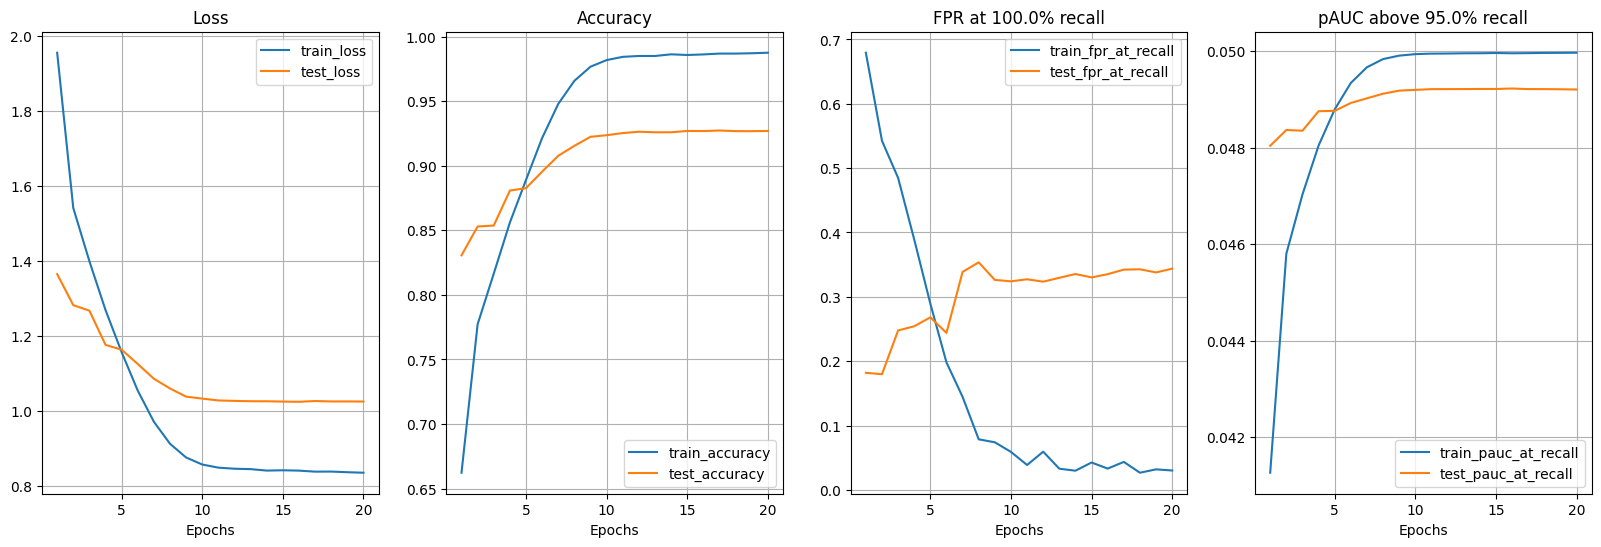

[INFO] Saving model to: ..\models\vitbase16_101_2025-01-27.pth
[INFO] Training finished! Elapsed time: 382m42s


In [7]:
# Train the model
model_type="vitbase16_101_2025-01-27"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
vitbase16_2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_2_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=10)

# Set seeds
set_seeds(SEED)

# And train...
train = Engine(
    model=vitbase16_2_model,
    save_best_model=True,
    mode=["acc", "loss", "fpr", "pauc"],
    device=device)

vitbase16_2_results = train.train(
    target_dir=MODEL_DIR,
    model_name=vitbase16_2_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=1.0,
    recall_threshold_pauc=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2
    )

In [8]:
vitbase16_2_results

epoch  train_loss  train_acc  train_fpr  train_pauc  train_time [s]  \
0       1    1.955666   0.662334   0.679374    0.041260      979.085072   
1       2    1.541661   0.777291   0.542462    0.045800      956.936041   
2       3    1.399884   0.816468   0.484831    0.047028      979.756160   
3       4    1.269661   0.855983   0.389053    0.048043      977.772673   
4       5    1.157290   0.889002   0.289340    0.048794      977.124798   
5       6    1.054847   0.921426   0.198088    0.049342      971.428509   
6       7    0.971891   0.947829   0.144492    0.049668      975.050004   
7       8    0.913203   0.965702   0.078532    0.049837      984.267038   
8       9    0.876557   0.976655   0.073923    0.049909      975.512330   
9      10    0.857899   0.981762   0.058997    0.049940      975.487544   
10     11    0.849600   0.984283   0.038654    0.049950      972.113640   
11     12    0.846721   0.984956   0.059341    0.049952      961.093174   
12     13    0.845628   0.984951   0.032910    0.049957      962.683760   
13     14    0.841741   0.986236   0.029797    0.049958      962.048064   
14     15    0.842575   0.985721   0.042509    0.049963      963.279555   
15     16    0.841647   0.986157   0.033065    0.049958      958.277322   
16     17    0.838919   0.986816   0.043460    0.049961      960.229845   
17     18    0.839130   0.986816   0.026644    0.049965      958.784787   
18     19    0.837432   0.987054   0.031861    0.049967      960.597331   
19     20    0.836061   0.987476   0.030098    0.049969      957.291347   

    test_loss  test_acc  test_fpr  test_pauc  test_time [s]        lr  
0    1.365549  0.830617  0.181923   0.048040     181.368438  0.000100  
1    1.282696  0.852967  0.179768   0.048366     170.921966  0.000098  
2    1.268088  0.853679  0.247741   0.048352     175.582892  0.000091  
3    1.176826  0.880775  0.254242   0.048756     177.873944  0.000080  
4    1.163917  0.882634  0.268139   0.048764     176.617921  0.000066  
5    1.125838  0.895411  0.243954   0.048928     176.007908  0.000051  
6    1.086581  0.907674  0.338779   0.049024     182.605977  0.000035  
7    1.060607  0.915388  0.353596   0.049119     183.127575  0.000021  
8    1.038790  0.922389  0.326276   0.049183     183.108434  0.000010  
9    1.033618  0.923616  0.324078   0.049199     179.637917  0.000003  
10   1.028760  0.925277  0.327279   0.049214     172.388402  0.000001  
11   1.027545  0.926305  0.323554   0.049215     173.958560  0.000001  
12   1.026660  0.925870  0.329571   0.049215     172.583231  0.000001  
13   1.026494  0.925910  0.335473   0.049218     173.015614  0.000001  
14   1.025706  0.926899  0.330165   0.049217     172.233588  0.000001  
15   1.025135  0.926820  0.335227   0.049227     172.393959  0.000001  
16   1.027159  0.927255  0.342290   0.049215     172.283833  0.000001  
17   1.026088  0.926780  0.342782   0.049215     175.460141  0.000001  
18   1.026129  0.926741  0.337934   0.049211     178.029958  0.000001  
19   1.025835  0.926899  0.343770   0.049206     175.632742  0.000001

In [9]:
# Instantiate the model
vitbase16_2_model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1).to(device)
vitbase16_2_model.heads = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Unfreeze the base parameters
for parameter in vitbase16_2_model.parameters():
    parameter.requires_grad = True

# Compile model
vitbase16_2_model = torch.compile(vitbase16_2_model, backend="aot_eager")

Epoch: 15 | Train: | loss: 0.8286 | acc: 0.9883 | fpr: 0.0147 | pauc: 0.0500 | time:  15m58s | lr: 0.0000020817
Epoch: 15 | Test:  | loss: 1.0407 | acc: 0.9230 | fpr: 0.3545 | pauc: 0.0491 | time:   2m53s | lr: 0.0000020817


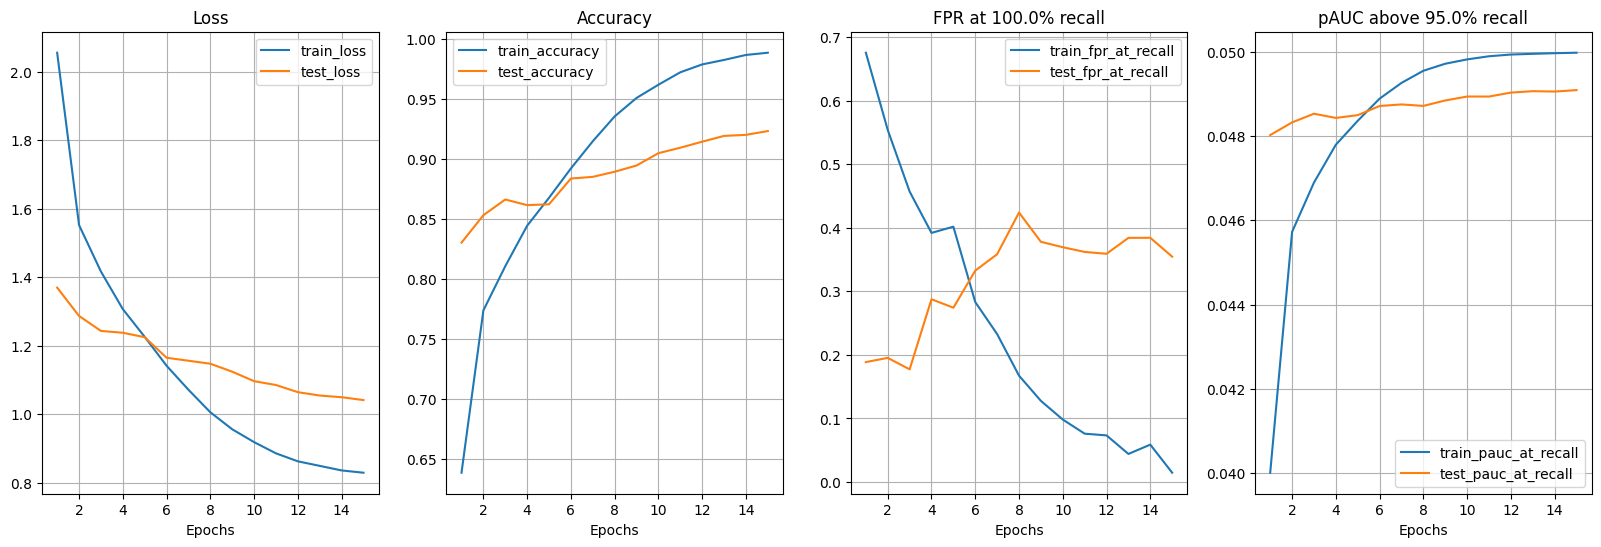

[INFO] Saving model to: ..\models\vitbase16_101_2025-01-28_acc_epoch15.pth
[INFO] Saving model to: ..\models\vitbase16_101_2025-01-28_loss_epoch15.pth
[INFO] Saving model to: ..\models\vitbase16_101_2025-01-28_pauc_epoch15.pth
[INFO] Saving model to: ..\models\vitbase16_101_2025-01-28.pth
[INFO] Training finished! Elapsed time: 284m32s


In [10]:
# Train the model
model_type="vitbase16_101_2025-01-28"
EPOCHS = 15
LR = 0.0001
model_name = f"{model_type}"
vitbase16_2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_2_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler=CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)
#scheduler = FixedLRSchedulerWrapper(
#    scheduler=CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6),
#    fixed_lr=1e-6,
#    fixed_epoch=10)

# Set seeds
set_seeds(SEED)

# And train...
train = Engine(
    model=vitbase16_2_model,
    save_best_model=True,
    mode=["acc", "loss", "fpr", "pauc"],
    device=device)

vitbase16_2_results = train.train(
    target_dir=MODEL_DIR,
    model_name=vitbase16_2_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=1.0,
    recall_threshold_pauc=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2
    )